In [ ]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import textwrap

sys.path.append(os.path.join(os.getcwd(), '../src'))
from utils import load_corpus_data
from metrics import calculate_topk_accuracy
import faissEncoder as faiss_enc


/home/fernandogd/Documents/Investigacion/Transformers/Repositories/ClinLinker-KB/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def compare_predictions(results, models):
    def compare_positions(row, df2):
        code = row['code']
        codes1 = row['codes']
        codes2 = df2.at[row.name, 'codes']

        position_df1 = codes1.index(code) if code in codes1 else float('inf')
        position_df2 = codes2.index(code) if code in codes2 else float('inf')

        return position_df1, position_df2
    N = len(models)
    comparison_matrix = np.zeros((N, N), dtype=int)

    for (i, j) in combinations(range(N), 2):
        df1, df2 = results[i], results[j]

        positions = df1.apply(compare_positions, df2=df2, axis=1)
        model1_earlier_count = np.sum(positions.apply(lambda x: x[0] < x[1]))
        model2_earlier_count = np.sum(positions.apply(lambda x: x[1] < x[0]))

        comparison_matrix[i, j] = model1_earlier_count
        comparison_matrix[j, i] = model2_earlier_count

    return pd.DataFrame(comparison_matrix, index=models, columns=models)

def plot_heatmap(
    comparisons_df: 'pd.DataFrame',
    corpus: str
) -> None:
    """
    This function generates and saves a heatmap based on the given DataFrame.
    
    Parameters:
    comparisons_df (pd.DataFrame): DataFrame with the data for the heatmap.
    corpus (str): Name of the corpus for naming the saved file.
    """
    plt.figure(figsize=(10, 8))

    ax = sns.heatmap(
        comparisons_df,
        annot=True,
        fmt='d',
        cmap='coolwarm',
        cbar=False,
        annot_kws={'size': 16}
    )

    ax.set_title(
        'Cleaned gold standard comparison',
        fontsize=20,
        fontweight='bold'
    )

    ax.set_xlabel('')
    ax.set_ylabel('')

    # Envolver etiquetas largas en X
    wrapped_x = ['\n'.join(textwrap.wrap(label, 10)) for label in comparisons_df.columns]
    ax.set_xticklabels(wrapped_x, rotation=0, ha='center', fontsize=14)

    # Envolver etiquetas largas en Y
    wrapped_y = ['\n'.join(textwrap.wrap(label, 10)) for label in comparisons_df.index]
    ax.set_yticklabels(wrapped_y, rotation=0, fontsize=14)

    plt.tight_layout()
    plt.savefig(
        f'../figures/{corpus}_cleaned_gold_standard_comparison.pdf',
        bbox_inches='tight'
    )
    plt.show()

In [3]:
CORPUS = "DisTEMIST"
DATA_PATH = "/scratch/data/"
models = []
results = []
F_TYPE = "FlatIP"
MAX_LENGTH = 256
TOP_N = 2
TOP_K_VALUES = [1,5,25,50,100,200]

In [4]:
test_df, train_df, gaz_df = load_corpus_data(DATA_PATH, CORPUS)
link_gaz_df = pd.concat([train_df[['code', 'term']], gaz_df[['code', 'term']]], ignore_index=True) 
no_code_count = test_df['code'].str.contains('NO_CODE').sum()
composite_count = test_df['code'].str.contains(r'\+').sum()
print(f"Number of NO_CODE: {no_code_count}")
print(f"Number of composite(+): {composite_count}")
test_df = test_df[~test_df['code'].str.contains('NO_CODE|\+', regex=True)]

Number of NO_CODE: 0
Number of composite(+): 91


In [5]:
gaz_df.head()

,code,language,term,semantic_tag,mainterm
0,9989000,es,anomalía congénita de dedo del pie,disorder,1
1,9989000,es,malformación congénita de dedo del pie,disorder,0
2,9984005,es,exfoliación de dientes por enfermedad sistémica,disorder,1
3,9982009,es,intoxicación causada por cocaína,disorder,1
4,998008,es,enfermedad de Chagas con compromiso del corazón,disorder,1


In [6]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker-KB-GP", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_granparent_preds = test_df.copy()
clinlinker_granparent_preds["candidates"] = candidates
clinlinker_granparent_preds["codes"] = codes
models.append("ClinLinker-KB-GP")
results.append(clinlinker_granparent_preds)
del faiss_encoder

2025-04-15 10:11:14,742 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-15 10:12:19,053 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [7]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker-KB-P", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_parent_preds = test_df.copy()
clinlinker_parent_preds["candidates"] = candidates
clinlinker_parent_preds["codes"] = codes
models.append("ClinLinker-KB-P")
results.append(clinlinker_parent_preds)
del faiss_encoder

2025-04-15 10:12:32,444 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-15 10:13:38,349 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [8]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_preds = test_df.copy()
clinlinker_preds["candidates"] = candidates
clinlinker_preds["codes"] = codes
models.append("ClinLinker")
results.append(clinlinker_preds)
del faiss_encoder

2025-04-15 10:13:51,168 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-15 10:14:59,473 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [9]:
faiss_encoder = faiss_enc.FaissEncoder("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
baseline_preds = test_df.copy()
baseline_preds["candidates"] = candidates
baseline_preds["codes"] = codes
models.append("SapBERT-XLM-R-large")
results.append(baseline_preds)
del faiss_encoder

2025-04-15 10:15:26,933 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-15 10:20:36,027 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [10]:
comparisons_df = compare_predictions(results, models)
comparisons_df.head()

,ClinLinker-KB-GP,ClinLinker-KB-P,ClinLinker,SapBERT-XLM-R-large
ClinLinker-KB-GP,0,361,429,481
ClinLinker-KB-P,320,0,393,452
ClinLinker,327,336,0,412
SapBERT-XLM-R-large,373,379,358,0


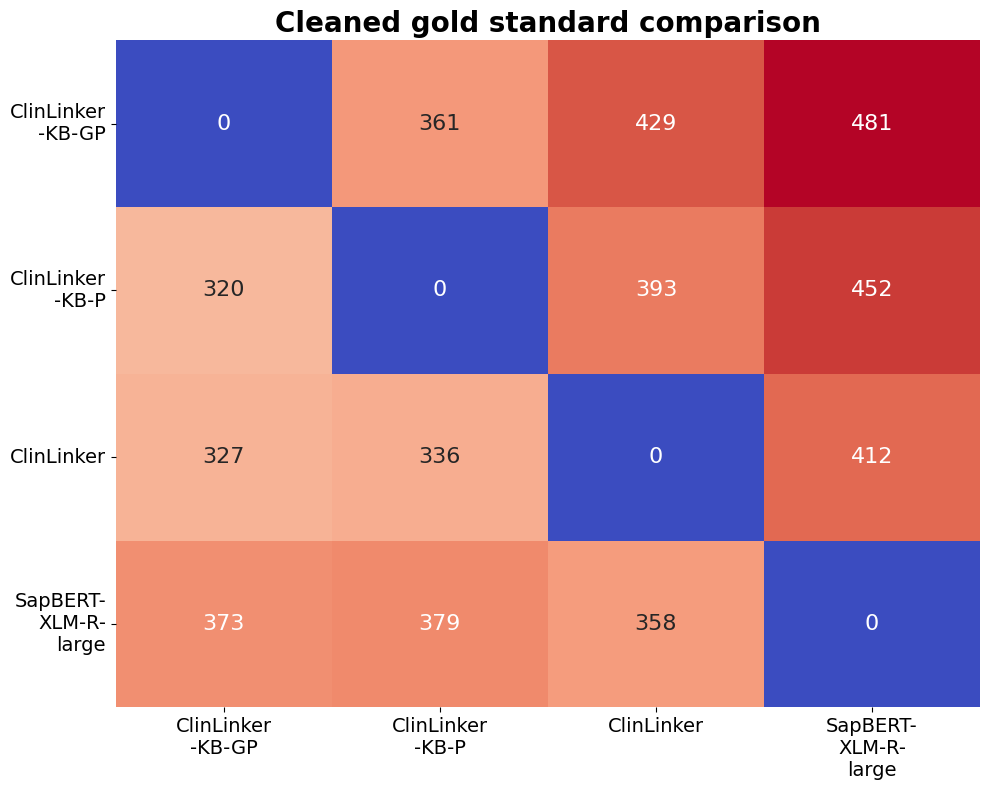

In [19]:
plot_heatmap(comparisons_df, CORPUS)
